<a href="https://colab.research.google.com/github/CGarcia8CG/BayesVSGridSearch/blob/main/BayesianSearch_vs_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and imports

In [1]:
!pip install scikit-optimize

In [12]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report
from skopt import BayesSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
import time


## Random Data

In [3]:
# Random data
X, y = make_classification(n_samples=10000, n_features=5, n_informative=4, n_redundant=1, n_clusters_per_class=2,
                           random_state=42, n_classes=2, weights={0:0.6, 1:0.4})

In [4]:
X_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
y_df = pd.DataFrame({'target': y})

# Concatenate X_df and y_df along columns (axis=1)
combined_df = pd.concat([X_df, y_df], axis=1)
print(combined_df.shape)
combined_df.head()

(10000, 6)


,feature_0,feature_1,feature_2,feature_3,feature_4,target
0,0.087048,2.426520,1.185854,1.782523,0.935856,1
1,-1.707593,0.122327,-0.604671,-0.905535,-0.692637,0
2,-0.981501,0.547214,-1.312135,-1.022361,0.818510,1
3,0.805849,-1.691910,-2.878510,-0.472700,-0.355966,0
4,-0.137834,-3.258149,-1.794420,-2.837373,-0.770304,1


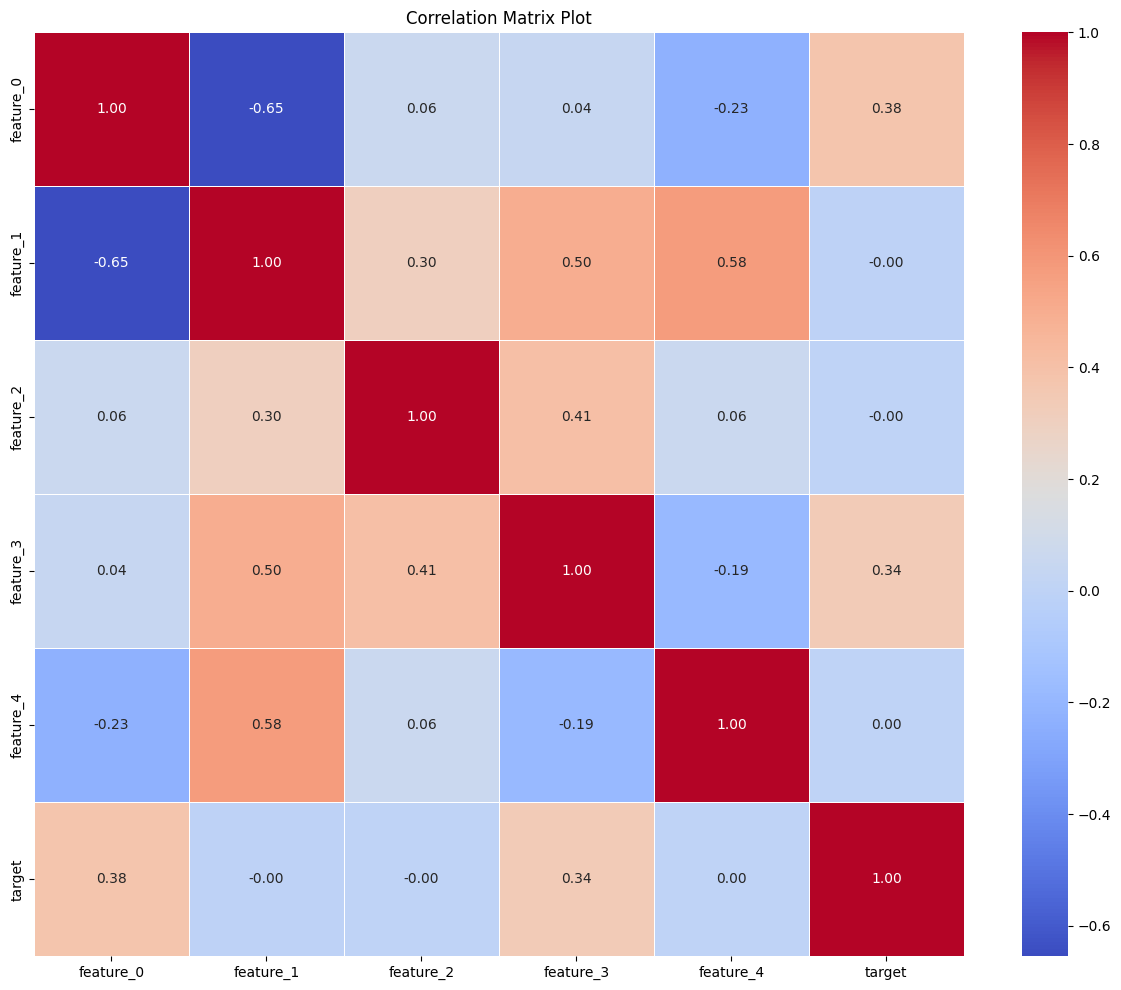

In [5]:
# Create a correlation matrix
correlation_matrix = combined_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix Plot')
plt.show()

In [6]:
X_combined = combined_df.drop(columns=['target'])  # Features
y_combined = combined_df['target']  # Target variable

# Split the data into training and testing sets
# Stratify for keep the unbalanced condition 60/40
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

In [7]:
y_train.value_counts()
y_test.value_counts()

0    1196
1     804
Name: target, dtype: int64

## GridSearch

In [9]:
# Define the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

f1_macro_scorer = make_scorer(f1_score, average='macro')

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring=f1_macro_scorer)

# Record the starting time
start_time = time.time()

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Record the ending time
end_time = time.time()

# Calculate the time taken
elapsed_time = end_time - start_time

# Display results
print("GridSearchCV - Best Parameters:", grid_search.best_params_)
print("GridSearchCV - Best F1-score (macro):", grid_search.best_score_)
print("Time taken:", elapsed_time, "seconds")

GridSearchCV - Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
GridSearchCV - Best F1-score (macro): 0.9251046882438965
Time taken: 937.2809057235718 seconds


## BayesianSearch

In [11]:
# Define the RandomForestClassifier
rf_classifier_bayes = RandomForestClassifier()

# Hyperparameter space for BayesianSearchCV
param_dist = {
    'n_estimators': (50, 200),
    'max_depth': (1, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

# Create BayesSearchCV instance with F1-score macro as the scoring metric
bayesian_search = BayesSearchCV(estimator=rf_classifier_bayes, search_spaces=param_dist, n_iter=50, cv=5, random_state=42, scoring=f1_macro_scorer)

# Record the starting time
start_timeb = time.time()

# Fit the model with BayesianSearchCV
bayesian_search.fit(X_train, y_train)

# Record the ending time
end_timeb = time.time()

# Calculate the time taken
elapsed_timeb = end_timeb - start_timeb

# Display results
print("BayesianSearchCV - Best Parameters:", bayesian_search.best_params_)
print("BayesianSearchCV - Best F1-score (macro):", bayesian_search.best_score_)
print("Time taken:", elapsed_timeb, "seconds")

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesianSearchCV - Best Parameters: OrderedDict([('max_depth', 16), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 60)])
BayesianSearchCV - Best F1-score (macro): 0.9240744495533386
Time taken: 607.0503149032593 seconds


## Comparison

In [14]:
# Predictions on the test set
y_pred_grid = grid_search.predict(X_test)

# Classification report for GridSearchCV model
print("GridSearchCV Model Classification Report:")
print(classification_report(y_test, y_pred_grid))

GridSearchCV Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1196
           1       0.94      0.92      0.93       804

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



In [15]:
# Predictions on the test set
y_pred_bayesian = bayesian_search.predict(X_test)

# Classification report for BayesianSearchCV model
print("\nBayesianSearchCV Model Classification Report:")
print(classification_report(y_test, y_pred_bayesian))


BayesianSearchCV Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1196
           1       0.94      0.92      0.93       804

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



<ipython-input-17-2808f73b7de5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Method', y='Time (seconds)', data=df, palette=['blue', 'orange'])


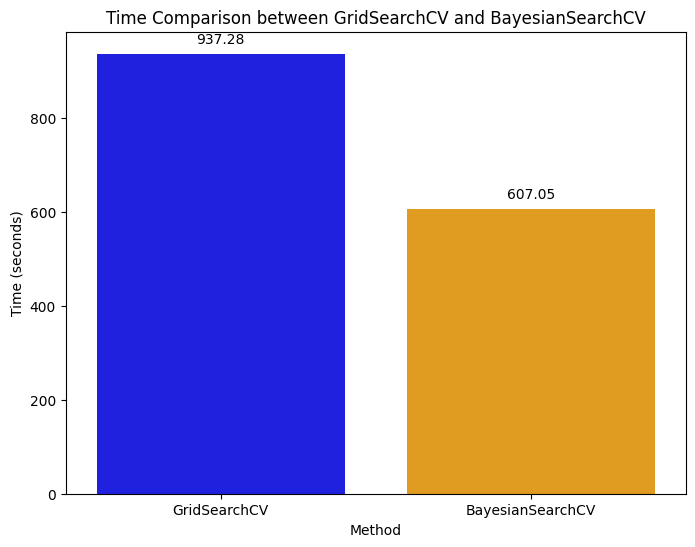

In [17]:
# Create a bar plot with seaborn
methods = ['GridSearchCV', 'BayesianSearchCV']
times = [elapsed_time, elapsed_timeb]

# Create a DataFrame for seaborn plotting
df = pd.DataFrame({'Method': methods, 'Time (seconds)': times})

# Plot with annotations
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Method', y='Time (seconds)', data=df, palette=['blue', 'orange'])

# Add text annotations at the center of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Time Comparison between GridSearchCV and BayesianSearchCV')
plt.show()